In [53]:
# Force garbage collection
import gc
gc.collect()

1993

In [4]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve

In [44]:
import pickle

In [55]:
yr = 2020
Eval_2020 = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{yr}_predictions.csv')

yr = 2007
Eval_2007 = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{yr}_predictions.csv')

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_38424\140054530.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  Eval_2020 = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{yr}_predictions.csv')
C:\Users\fangshuye\AppData\Local\Temp\ipykernel_38424\140054530.py:5: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  Eval_2007 = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{yr}_predictions.csv')


In [59]:
significant_tread_variables = ['pdsi_pre_interpolated', 
                               'max_air_temperature', 
                               'min_air_temperature', 
                               'specific_humidity', 
                               'wind_speed', 
                               'LAI', 
                               'surface_downwelling_shortwave_flux_in_air', 
                               'precipitation_amount']
# check if significant_tread variables are in the Eval_2006 and Eval_2020 dataframes
for var in significant_tread_variables:
    if var not in Eval_2007.columns:
        print(f"{var} not found in 2006 data")

# check if the columns are in the same order
if list(Eval_2007.columns) != list(Eval_2020.columns):
    print("Columns are not in the same order")

In [60]:
Eval_2020.shape, Eval_2007.shape

((6204578, 59), (6176348, 59))

In [61]:
if not Eval_2007.duplicated(subset=['lon', 'lat', 'day']).any():
    print("Eval_2007 lon, lat, day are unique")
else:
    print("Eval_2007 lon, lat, day are not unique")

if not Eval_2020.duplicated(subset=['lon', 'lat', 'day']).any():
    print("Eval_2020 lon, lat, day are unique")
else:
    print("Eval_2020 lon, lat, day are not unique")

Eval_2007 lon, lat, day are unique
Eval_2020 lon, lat, day are unique


In [62]:
# add a column date mm-dd from yyyy-mm-dd
Eval_2007['date'] = pd.to_datetime(Eval_2007['day']).dt.strftime('%m-%d')
Eval_2020['date'] = pd.to_datetime(Eval_2020['day']).dt.strftime('%m-%d')

In [63]:
# drop significant_tread variables from Eval_2020
Eval_2020 = Eval_2020.drop(columns=significant_tread_variables)
# only keep lon, lat, day, and significant_tread_variables columns in Eval_2007
Eval_2007 = Eval_2007[['lon', 'lat', 'date'] + significant_tread_variables]
Eval_2007.shape, Eval_2020.shape

((6176348, 11), (6204578, 52))

In [64]:
# check the common columns in both dataframes
common_columns = set(Eval_2007.columns).intersection(set(Eval_2020.columns))
print(f"Common columns: {common_columns}")

Common columns: {'date', 'lon', 'lat'}


In [65]:
# merge the two dataframes on lon, lat, and day
Eval_2020_reset_climate = Eval_2020.merge(Eval_2007, on=['lon', 'lat', 'date'], how = "inner")

In [66]:
Eval_2020_reset_climate.shape

(6059451, 60)

In [45]:
yr = 2020
with open(f'../Model/6_year_completed/predict_{yr}_6yr_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [67]:
Eval_2020_reset_climate.columns

Index(['lon', 'lat', 'day', 'dead_fuel_moisture_1000hr',
       'dead_fuel_moisture_100hr', 'pdsi_class', 'max_relative_humidity',
       'max_wind_speed', 'min_relative_humidity', 'wind_from_direction', 'SWE',
       'Band1', 'pdsi', 'population_density_log', 'IS_FIRE',
       'NWCG_CAUSE_CLASSIFICATION', 'min_FIRE_SIZE', 'max_FIRE_SIZE', 'Year',
       'veg_type_details', 'fire_attribute', 'slope_avg', 'slope_max',
       'road_density_km_km2', 'road_density_km_km2_log',
       'wind_direction_category_N', 'wind_direction_category_NE',
       'wind_direction_category_E', 'wind_direction_category_SE',
       'wind_direction_category_S', 'wind_direction_category_SW',
       'wind_direction_category_W', 'wind_direction_category_NW',
       'veg_Agriculture ', 'veg_Barren ', 'veg_Native Chapparal ',
       'veg_Native Coastal Sage Scrub ', 'veg_Native Conifer Alpine ',
       'veg_Native Conifer Forest ', 'veg_Native Desert ',
       'veg_Native Grassland ', 'veg_Native Inland Scrub ',
 

In [68]:
features = loaded_model.get_booster().feature_names

In [83]:
# predict the probability of fire for 2020 using the loaded model
Eval_2020_reset_climate['predictions_update'] = loaded_model.predict_proba(Eval_2020_reset_climate[features])[:, 1]

In [73]:
# add a column Month from the date column
Eval_2020_reset_climate['Month'] = pd.to_datetime(Eval_2020_reset_climate['date'], format='%m-%d').dt.month

In [84]:
Eval_2020_reset_climate_grouped = Eval_2020_reset_climate.groupby('Month').agg(
    predictions_update_median=('predictions_update', 'median'),
    predictions_update_q25=('predictions_update', lambda x: x.quantile(0.25)),
    predictions_update_q75=('predictions_update', lambda x: x.quantile(0.75)),
    predictions_median=('predictions', 'median'),
    predictions_q25=('predictions', lambda x: x.quantile(0.25)),
    predictions_q75=('predictions', lambda x: x.quantile(0.75))
).reset_index()

Eval_2020_reset_climate_grouped

,Month,predictions_update_median,predictions_update_q25,predictions_update_q75,predictions_median,predictions_q25,predictions_q75
0,1,0.000286,0.000074,0.001064,0.000256,0.000062,0.000948
1,2,0.000764,0.000216,0.002923,0.000925,0.000293,0.003115
2,3,0.000967,0.000298,0.003078,0.000592,0.000145,0.002200
3,4,0.001040,0.000337,0.003549,0.000979,0.000292,0.003487
4,5,0.002336,0.000832,0.008155,0.002039,0.000753,0.007155
5,6,0.003178,0.001302,0.010165,0.002981,0.001254,0.009390
6,7,0.003774,0.001857,0.010274,0.003696,0.001875,0.010384
7,8,0.003363,0.001728,0.008599,0.003193,0.001700,0.008284
8,9,0.003185,0.001519,0.007898,0.003119,0.001529,0.007962
9,10,0.002726,0.001177,0.007426,0.002486,0.001145,0.006731


In [87]:
def plot_comparison(Eval_2020_reset_climate_grouped):
    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

    # Define labels and titles
    metrics = ['median', 'q25', 'q75']
    titles = ["Median Comparison", "25th Percentile Comparison (Q25)", "75th Percentile Comparison (Q75)"]
    colors = ['blue', 'red']

    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Plot updated values
        ax.plot(Eval_2020_reset_climate_grouped['Month'], Eval_2020_reset_climate_grouped[f'predictions_update_{metric}'], marker='o', color=colors[0], label=f'Updated {metric}')
        
        # Plot old values
        ax.plot(Eval_2020_reset_climate_grouped['Month'], Eval_2020_reset_climate_grouped[f'predictions_{metric}'], marker='o', color=colors[1], label=f'Old {metric}')
        
        ax.set_title(titles[i])
        ax.set_xlabel("Month")
        ax.set_ylabel(f"{metric.capitalize()} Value")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

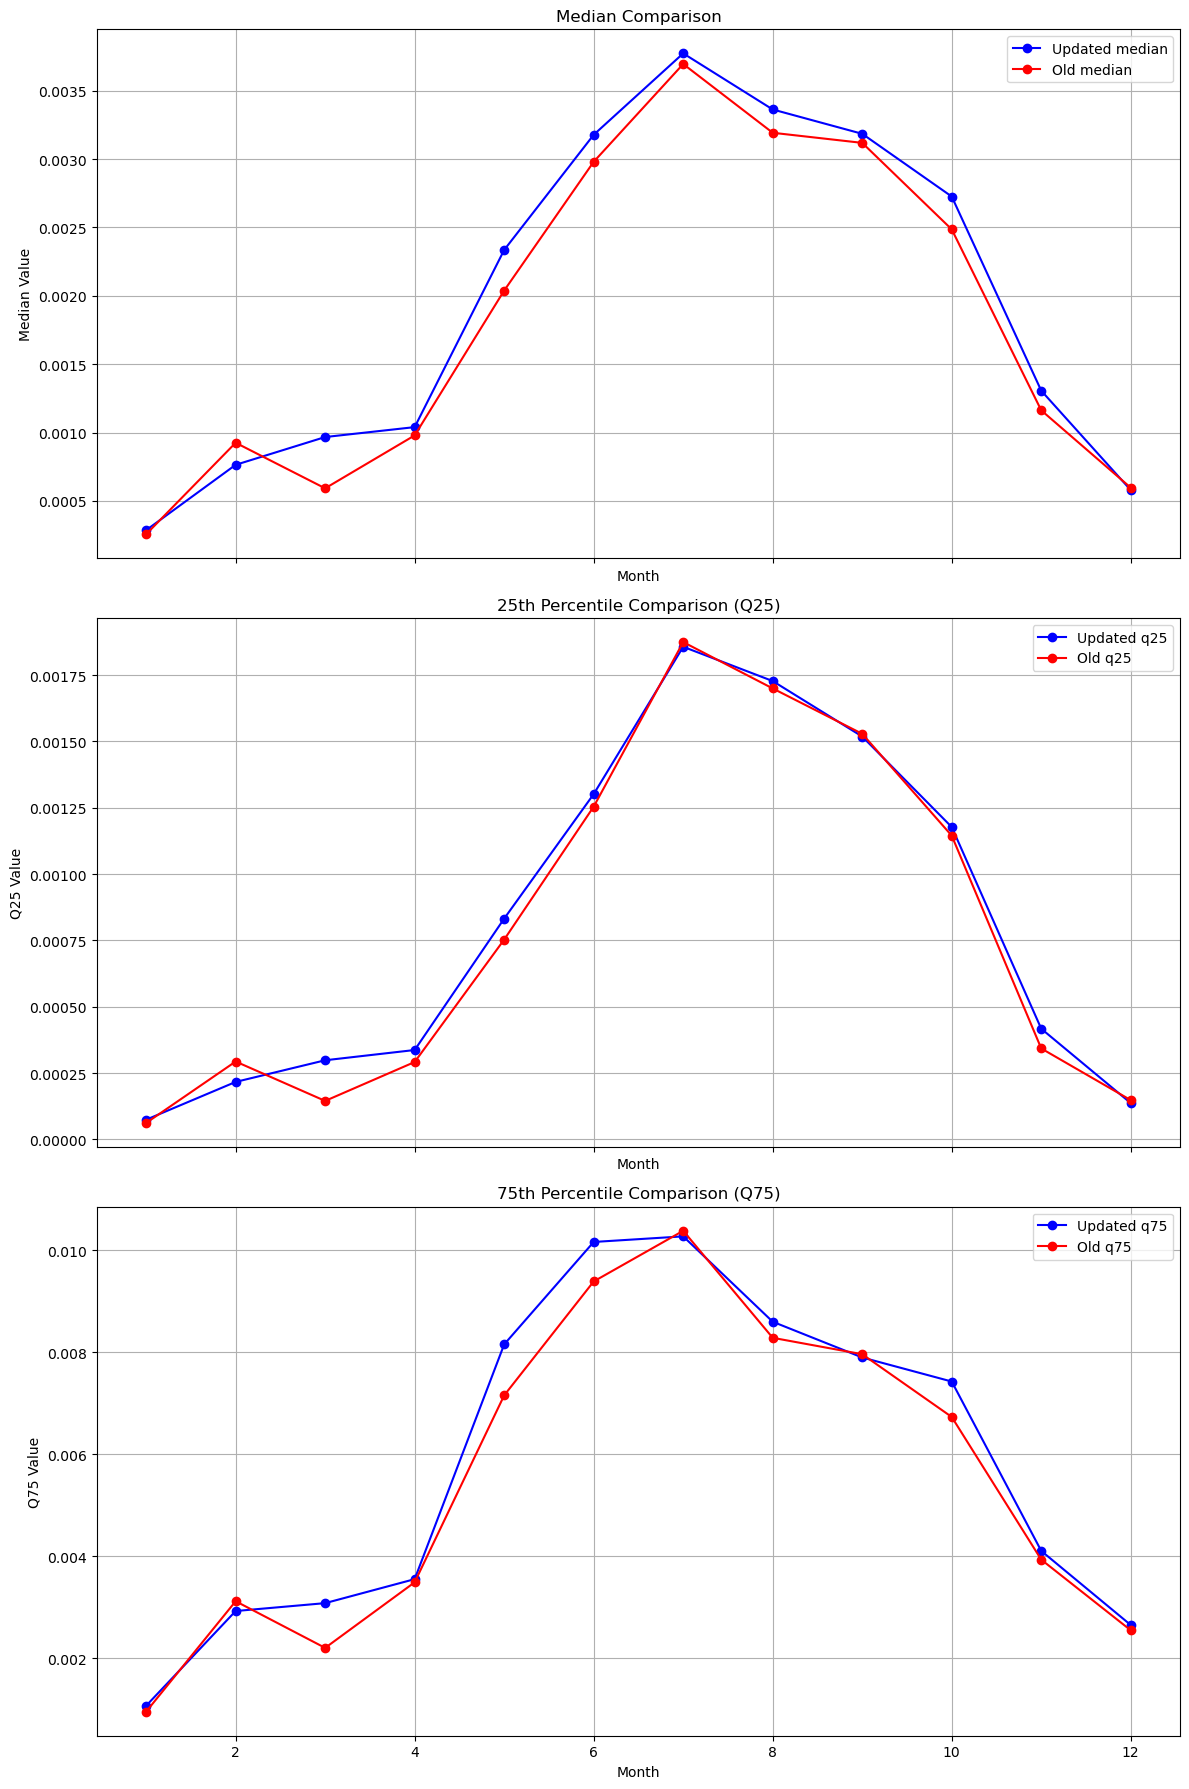

In [88]:
plot_comparison(Eval_2020_reset_climate_grouped)

In [89]:
# save data
Eval_2020_reset_climate_grouped.to_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/2020_predictions_using_2007.csv', index=False)